In [204]:
%matplotlib inline
import numpy as np
import pypico
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

In [205]:
# Note i didn't upload the data file to github as it's too large
# comment my path and change to your own path to see data

# pico data on pypico's github
pico = pypico.load_pico("../data/jcset_py3.dat")
# FROM: http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')

/var/folders/_2/d0xmq0nn39z8s3ccvbbr049h0000gn/T/ipykernel_69938/2570485871.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')


In [206]:
# example parameters from pypico
As = 2.08e-9
ns = 0.97
tau = 0.055
ombh2 = 0.0225
omch2 = 0.117
H0 = 50
omk = -0.05
pivot_scalar = 0.05


In [207]:
df

,l,Dl,-dDl,+dDl
0,2.0,225.895000,132.369000,533.062000
1,3.0,936.920000,450.471000,1212.308000
2,4.0,692.238000,294.111000,666.469000
3,5.0,1501.705000,574.432000,1155.804000
4,6.0,557.611000,201.242000,375.763000
...,...,...,...,...
2502,2504.0,212.915616,110.537143,110.537143
2503,2505.0,54.752355,110.824874,110.824874
2504,2506.0,-149.315007,111.110198,111.110198
2505,2507.0,-71.474213,111.427400,111.427400


note that
\begin{equation}
D_l = C_{l}\frac{l(l + 1)}{2\pi}
\end{equation}

In [208]:
def model(As, ns, tau, ombh2, omch2, H0, omk, pico=pico):
    '''
    to generate the model datas with pico

    Parameters
    ----------
    As, ns, tau, ombh2, omch2, H0, omk: parameters of model
    pico: pico object, to choose your model

    Returns
    ----------
    power spectrum
    '''
    #load our input dire
    input_dir = {'As': As,
                'ns': ns,
                'tau': tau,
                'ombh2': ombh2,
                'omch2': omch2,
                'H0': H0,
                'omk': omk}

    result = pico.get(**input_dir, force=True)      # set True as we will use MCMC
    dl_TT = result['dl_TT']

    # TODO: the pico.outputs() gives ['cl_TT']; the result above gives ['dl_TT']
    # do i have to transfer as above?
    #cl_TT = [dl_TT[i]*2*np.pi/(i*(i+1)) for i in range(len(dl_TT))]

    return dl_TT


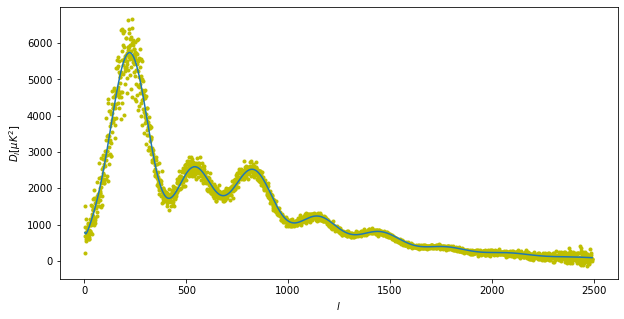

In [209]:
# just plot to make sure we are on the right track
dl = model(As, ns, tau, ombh2, omch2, H0, omk)
dl = dl[2:]

plt.figure(figsize=(10, 5))
#plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0)
plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.plot(df['l'][:len(dl)], dl)
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")
plt.show()

In [210]:
# helper function for MCMC

def log_prior(theta):
    As, ns, tau, ombh2, omch2, H0, omk = theta
    if (20 < H0 < 100 and .005 < ombh2 < .1 and .001 < omch2 < .99 and .01 < tau < .2 and .8 < ns < 1.2 and 1e-10 < As < 9e-9):
        return 0
    return -np.inf


def log_likeli(theta, df=df):
    #load data
    As, ns, tau, ombh2, omch2, H0, omk = theta
    dmodel = model(As, ns, tau, ombh2, omch2, H0, omk)
    data = df.copy()
    # keep l of model and data the same
    dmodel = dmodel[2:]
    data = data[:len(dmodel)]

    data['err'] = (data['+dDl'] + data['-dDl']) / 2
    data['err2'] = data['err']**2

    return -0.5 * np.sum(((data['Dl'] - dmodel)/data['err2']) ** 2  + np.log(data['err2'])*2*np.pi)


def log_post(theta, df=df):
    data = df.copy()
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likeli(theta, df=df)

In [211]:
# set MCMC
nwalkers = 30
ndim = 7

num_iter = 5000

pos = 0.01*np.random.rand(nwalkers, ndim)+1
pos[:, 0] *= As
pos[:, 1] *= ns
pos[:, 2] *= tau
pos[:, 3] *= ombh2
pos[:, 4] *= omch2
pos[:, 5] *= H0
pos[:, 6] *= omk

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
sampler.run_mcmc(pos, num_iter, progress=True)

100%|██████████| 5000/5000 [06:40<00:00, 12.48it/s]


State([[ 2.18853706e-09  9.87010358e-01  6.69986324e-02  2.80230093e-02
   9.44612915e-02  2.89325979e+01 -4.54673780e-01]
 [ 2.60265896e-09  9.99664189e-01  1.11008974e-01  1.25692505e-02
   1.11384102e-01  5.02961244e+01 -3.08625897e-02]
 [ 2.27928522e-09  1.06494356e+00  1.62070798e-01  2.27497072e-02
   1.43907450e-01  6.13796668e+01  3.28951044e-02]
 [ 2.66813972e-09  9.72983766e-01  1.49068633e-01  1.71550395e-02
   7.87282200e-02  2.86992284e+01 -4.10348288e-01]
 [ 2.40072543e-09  9.78025761e-01  5.76087439e-02  1.94657849e-02
   1.90557636e-01  4.20051045e+01 -2.05511080e-02]
 [ 1.90844887e-09  1.02047500e+00  2.00921469e-02  1.99462878e-02
   1.64947835e-01  6.51392761e+01  3.28374418e-02]
 [ 2.16115886e-09  9.58277032e-01  3.63865613e-02  2.41310246e-02
   1.89499189e-01  3.89899088e+01 -1.19926983e-01]
 [ 2.98517535e-09  9.03271471e-01  1.67458488e-01  2.39516996e-02
   3.10138081e-01  3.10170399e+01  3.86519825e-02]
 [ 2.15712637e-09  8.85520299e-01  1.06264615e-02  1.86449

In [217]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

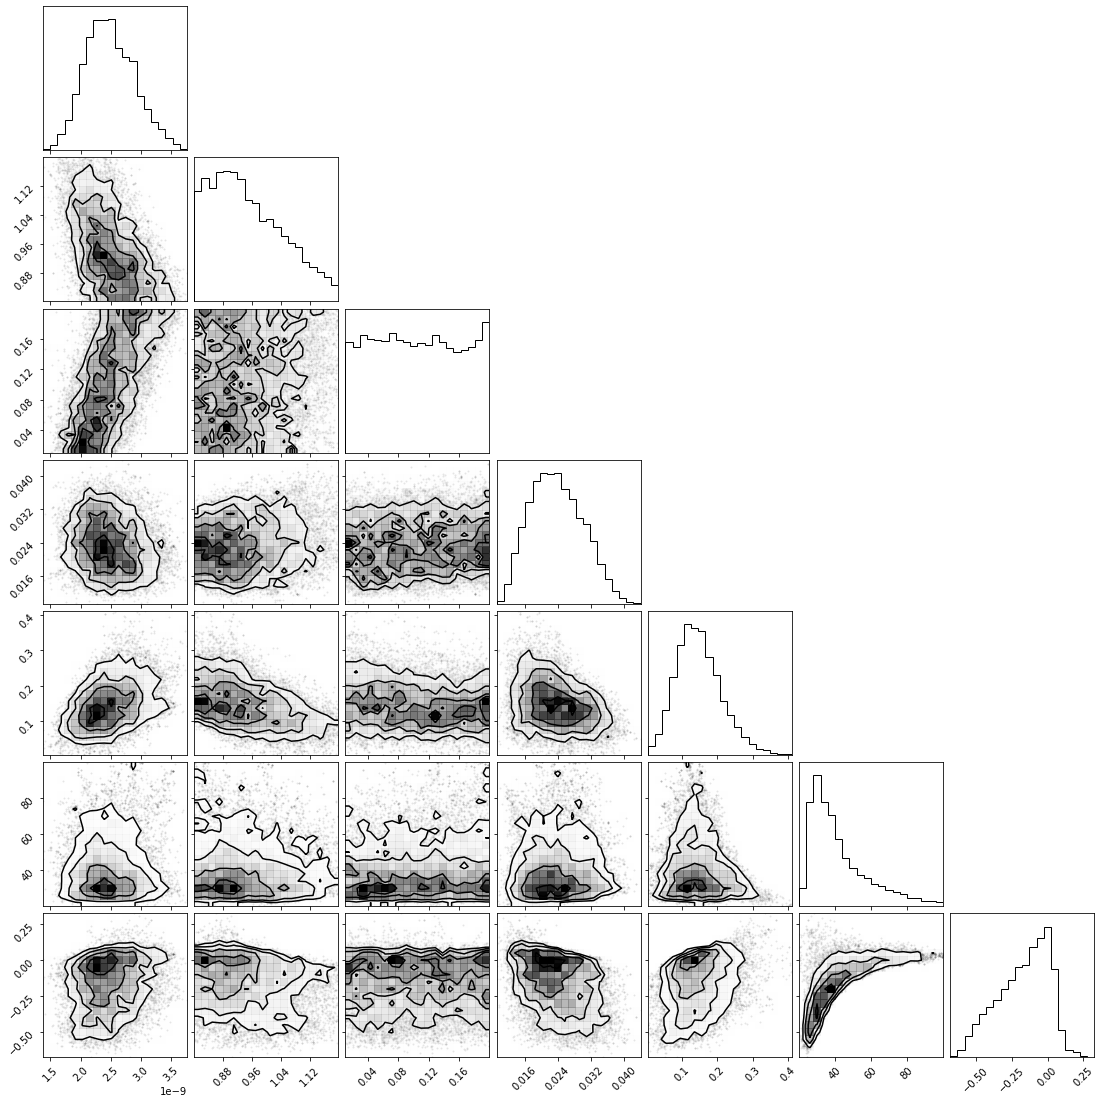

In [218]:
fig = corner.corner(flat_samples)

In [219]:
flat_samples[1238]

array([ 2.36523886e-09,  9.12063382e-01,  1.72277240e-01,  1.87862051e-02,
        5.04593208e-02,  2.48385405e+01, -5.35859840e-01])

Text(0, 0.5, '$D_{l} [\\mu K^2]$')

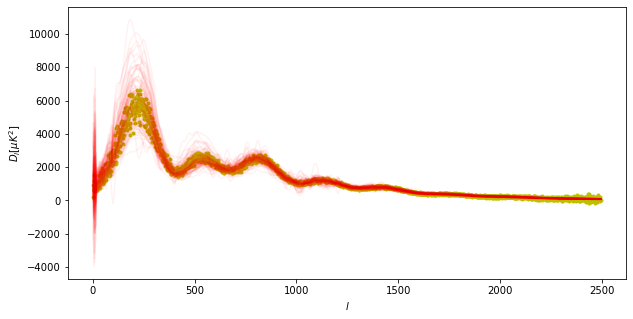

In [220]:
inds = np.random.randint(len(flat_samples), size=100)
x = df['l'][:len(dl)]

plt.figure(figsize=(10, 5))
for ind in inds:
    s = flat_samples[ind]
    As_s, ns_s, tau_s, ombh2_s, omch2_s, H0_s, omk_s = s
    dl_s = model(As_s, ns_s, tau_s, ombh2_s, omch2_s, H0_s, omk_s)[2:]
    plt.plot(x, dl_s, alpha=0.05, color='red')
#plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0)
plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")